In [14]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.models import load_model
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
#import sys
import cv2
from keras import Model
import matplotlib.pyplot as plt
import os

In [2]:
image_size_shape=(299, 299)

In [19]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape


In [4]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


In [5]:
#your image_size and preprocessing
def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=image_size_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [6]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [7]:
#Notice block5_conv3
def compile_saliency_function(model, activation_layer):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [8]:
#change your new_model
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
#         new_model = VGG16(weights='imagenet')
    return model

In [9]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x



In [17]:
def grad_cam(input_model, image, category_index, layer_name):
    #Notice nv_classes
    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(input_model.output)
    
    model = Model(inputs=input_model.input, outputs=x)
#     model.summary()
    #loss = K.sum(model.output)
    loss = K.sum(model.layers[-1].output)  
    conv_output =  [l for l in model.layers if l.name == layer_name][0].output
    grads = normalize(_compute_gradients(loss, [conv_output])[0])
    gradient_function = K.function([model.input], [conv_output, grads])
    
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    
    #image_size!!!!
    cam = cv2.resize(cam, image_size_shape)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap



In [11]:
def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var)for var, grad in zip(var_list, grads)]

In [12]:
preprocessed_input = load_image('datasets/test/normal/Image_2018_10_18_134508.162.jpg')

In [15]:
model_path = os.path.join('saved_models', 'ir2transfer_learning.h5')
model = load_model(model_path)

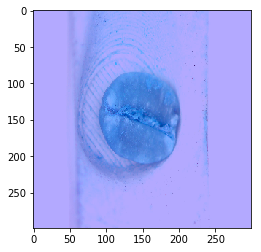

In [29]:
#preprocessed_input = load_image(sys.argv[1])
# model = VGG16(weights='imagenet')

predictions = model.predict(preprocessed_input)

#用不到時關起來
# top_1 = decode_predictions(predictions)[0][0]
# print('Predicted class:')
# print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))
layer = 'conv_7b_ac'
predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv_7b_ac")
# cv2.imwrite("gradcam.jpg", cam)
plt.imshow(cam, cmap='gray')

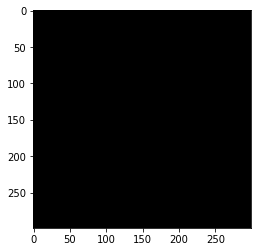

In [30]:
plt.imshow(heatmap, cmap='gray')

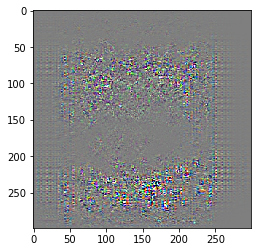

In [31]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model, layer)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
# cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))
plt.imshow(deprocess_image(gradcam), cmap='gray')